<a href="https://colab.research.google.com/github/Ananyaa00051/news--analysis-project-beautiful-soup-python/blob/main/News_Analysis_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required libraries
!pip install requests beautifulsoup4 pandas matplotlib seaborn plotly wordcloud textblob

# Import all libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud
from textblob import TextBlob
import re
import time
import warnings
from datetime import datetime, timedelta
from collections import Counter
import numpy as np

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("✅ All libraries installed successfully!")

✅ All libraries installed successfully!


In [2]:
def scrape_hackernews_stories(max_pages=5):
    """
    Scrape stories from HackerNews front page
    """
    all_stories = []
    base_url = "https://news.ycombinator.com"

    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
    }

    for page in range(1, max_pages + 1):
        print(f"📄 Scraping page {page}...")

        try:
            if page == 1:
                url = base_url
            else:
                url = f"{base_url}?p={page}"

            response = requests.get(url, headers=headers, timeout=10)
            response.raise_for_status()

            soup = BeautifulSoup(response.text, 'html.parser')

            # Find all story rows
            story_rows = soup.find_all('tr', class_='athing')

            for story in story_rows:
                try:
                    # Get story ID
                    story_id = story.get('id')

                    # Get title and URL
                    title_cell = story.find('span', class_='titleline')
                    if not title_cell:
                        continue

                    title_link = title_cell.find('a')
                    if not title_link:
                        continue

                    title = title_link.text.strip()
                    url = title_link.get('href', '')

                    # Get domain
                    domain_span = title_cell.find('span', class_='sitestr')
                    domain = domain_span.text if domain_span else 'news.ycombinator.com'

                    # Find the next row with metadata
                    meta_row = story.find_next_sibling('tr')
                    if not meta_row:
                        continue

                    score_span = meta_row.find('span', class_='score')
                    score = int(re.findall(r'\d+', score_span.text)[0]) if score_span else 0

                    # Get comments count
                    comment_links = meta_row.find_all('a')
                    comments = 0
                    for link in comment_links:
                        if 'comment' in link.text:
                            comments_match = re.findall(r'(\d+)', link.text)
                            if comments_match:
                                comments = int(comments_match[0])
                            break

                    # Get author
                    author_link = meta_row.find('a', class_='hnuser')
                    author = author_link.text if author_link else 'Unknown'

                    # Get time (approximate)
                    time_span = meta_row.find('span', class_='age')
                    time_text = time_span.get('title') if time_span else 'Unknown'

                    # Store the story data
                    story_data = {
                        'id': story_id,
                        'title': title,
                        'url': url,
                        'domain': domain,
                        'score': score,
                        'comments': comments,
                        'author': author,
                        'time_posted': time_text,
                        'title_length': len(title),
                        'page': page
                    }

                    all_stories.append(story_data)

                except Exception as e:
                    print(f"⚠️ Error parsing story: {e}")
                    continue

            # Be respectful - wait between pages
            if page < max_pages:
                time.sleep(2)

        except Exception as e:
            print(f"❌ Error scraping page {page}: {e}")
            continue

    return all_stories

# Scrape the data
print("🚀 Starting HackerNews scraping...")
stories_data = scrape_hackernews_stories(max_pages=3)
print(f"✅ Scraped {len(stories_data)} stories successfully!")

# Create DataFrame
df = pd.DataFrame(stories_data)
print("\n📊 Data Preview:")
print(df.head())
print(f"\nDataset shape: {df.shape}")

🚀 Starting HackerNews scraping...
📄 Scraping page 1...
📄 Scraping page 2...
📄 Scraping page 3...
✅ Scraped 90 stories successfully!

📊 Data Preview:
         id                                              title  \
0  44980865  Io_uring, kTLS and Rust for zero syscall HTTPS...   
1  44976764                                      DeepSeek-v3.1   
2  44980339                           Everything Is Correlated   
3  44980004  Control shopping cart wheels with your phone (...   
4  44982409  LabPlot: Free, open source and cross-platform ...   

                                                 url            domain  score  \
0  https://blog.habets.se/2025/04/io-uring-ktls-a...         habets.se    247   
1      https://api-docs.deepseek.com/news/news250821      deepseek.com    549   
2                       https://gwern.net/everything         gwern.net    128   
3                      https://www.begaydocrime.com/  begaydocrime.com    179   
4                               https://labplot.o

In [3]:
# Clean and enhance the data
def clean_and_enhance_data(df):
    """
    Clean the scraped data and add useful features
    """
    df_clean = df.copy()

    # Clean domains - extract main domain
    df_clean['clean_domain'] = df_clean['domain'].str.replace('www.', '').str.lower()

    # Categorize domains
    tech_domains = ['github.com', 'stackoverflow.com', 'medium.com', 'dev.to', 'techcrunch.com']
    news_domains = ['bbc.com', 'cnn.com', 'reuters.com', 'nytimes.com', 'theguardian.com']

    def categorize_domain(domain):
        domain = domain.lower()
        if any(tech in domain for tech in tech_domains):
            return 'Tech'
        elif any(news in domain for news in news_domains):
            return 'News'
        elif 'github' in domain:
            return 'Code'
        elif 'youtube' in domain or 'video' in domain:
            return 'Video'
        elif domain == 'news.ycombinator.com':
            return 'Discussion'
        else:
            return 'Other'

    df_clean['category'] = df_clean['clean_domain'].apply(categorize_domain)

    # Analyze title sentiment
    def get_sentiment(title):
        try:
            blob = TextBlob(title)
            return blob.sentiment.polarity
        except:
            return 0

    df_clean['sentiment'] = df_clean['title'].apply(get_sentiment)
    df_clean['sentiment_label'] = pd.cut(df_clean['sentiment'],
                                       bins=[-1, -0.1, 0.1, 1],
                                       labels=['Negative', 'Neutral', 'Positive'])

    # Extract keywords from titles
    def extract_tech_keywords(title):
        tech_keywords = ['AI', 'machine learning', 'python', 'javascript', 'react', 'blockchain',
                        'crypto', 'startup', 'google', 'apple', 'microsoft', 'amazon', 'meta',
                        'openai', 'chatgpt', 'github', 'docker', 'kubernetes', 'cloud']

        title_lower = title.lower()
        found_keywords = [kw for kw in tech_keywords if kw.lower() in title_lower]
        return ', '.join(found_keywords) if found_keywords else 'None'

    df_clean['tech_keywords'] = df_clean['title'].apply(extract_tech_keywords)

    # Score to comments ratio
    df_clean['engagement_ratio'] = df_clean['score'] / (df_clean['comments'] + 1)

    return df_clean

# Clean the data
df_clean = clean_and_enhance_data(df)
print("🧹 Data cleaned and enhanced!")
print(f"New columns added: {set(df_clean.columns) - set(df.columns)}")

🧹 Data cleaned and enhanced!
New columns added: {'sentiment', 'clean_domain', 'tech_keywords', 'engagement_ratio', 'category', 'sentiment_label'}


In [4]:
# 1. Interactive histogram of scores
fig = px.histogram(df_clean, x='score',
                   title='📊 Distribution of Story Scores on HackerNews',
                   labels={'score': 'Score (Points)', 'count': 'Number of Stories'},
                   color_discrete_sequence=['#ff6b6b'])

fig.update_layout(
    title_font_size=16,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    showlegend=False,
    template='plotly_white'
)

fig.show()

# Add some statistics
print(f"📈 Score Statistics:")
print(f"Average Score: {df_clean['score'].mean():.1f}")
print(f"Median Score: {df_clean['score'].median():.1f}")
print(f"Highest Score: {df_clean['score'].max()}")
print(f"Stories with 100+ points: {len(df_clean[df_clean['score'] >= 100])}")

📈 Score Statistics:
Average Score: 191.7
Median Score: 138.5
Highest Score: 1402
Stories with 100+ points: 53


In [5]:
# 2. Top domains analysis
domain_stats = df_clean['clean_domain'].value_counts().head(15)

fig = px.bar(x=domain_stats.index, y=domain_stats.values,
             title='🌐 Top 15 Domains on HackerNews Front Page',
             labels={'x': 'Domain', 'y': 'Number of Stories'},
             color=domain_stats.values,
             color_continuous_scale='Viridis')

fig.update_layout(
    xaxis_tickangle=-45,
    title_font_size=16,
    template='plotly_white'
)

fig.show()

print(f"📊 Total unique domains: {df_clean['clean_domain'].nunique()}")

📊 Total unique domains: 84


In [6]:
# 3. Category breakdown
category_counts = df_clean['category'].value_counts()

fig = px.pie(values=category_counts.values,
             names=category_counts.index,
             title='📱 Story Categories on HackerNews',
             color_discrete_sequence=px.colors.qualitative.Set3)

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(title_font_size=16)

fig.show()

In [7]:
# 4. Score vs Comments relationship
fig = px.scatter(df_clean, x='score', y='comments',
                 color='category', size='title_length',
                 hover_data=['title', 'domain'],
                 title='💬 Relationship: Score vs Comments',
                 labels={'score': 'Score (Points)', 'comments': 'Number of Comments'})

fig.update_layout(
    title_font_size=16,
    template='plotly_white'
)

fig.show()

# Calculate correlation
correlation = df_clean['score'].corr(df_clean['comments'])
print(f"📊 Correlation between Score and Comments: {correlation:.3f}")

📊 Correlation between Score and Comments: 0.749


In [8]:
# 5. Sentiment analysis
sentiment_by_category = df_clean.groupby(['category', 'sentiment_label']).size().unstack(fill_value=0)

fig = px.bar(sentiment_by_category,
             title='😊 Sentiment Analysis by Category',
             labels={'value': 'Number of Stories', 'index': 'Category'},
             color_discrete_sequence=['#ff4757', '#ffa502', '#2ed573'])

fig.update_layout(
    xaxis_title='Category',
    yaxis_title='Number of Stories',
    title_font_size=16,
    template='plotly_white'
)

fig.show()

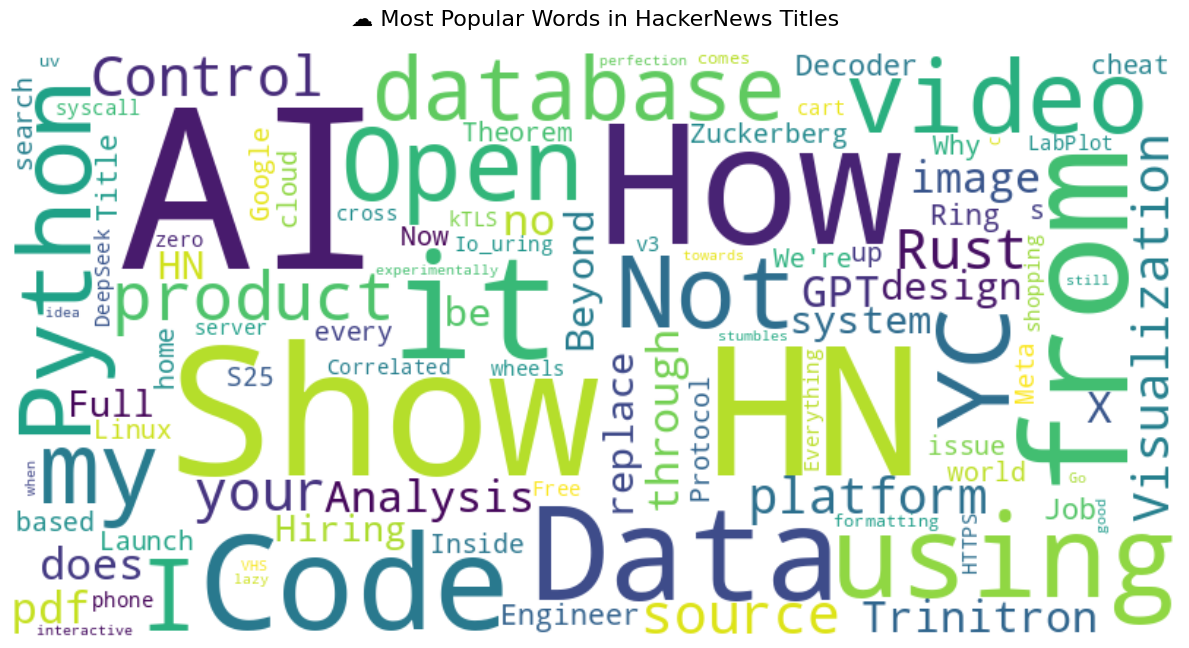

In [9]:
# 6. Word Cloud of popular words in titles
plt.figure(figsize=(12, 8))

# Combine all titles
all_titles = ' '.join(df_clean['title'].tolist())

# Create word cloud
wordcloud = WordCloud(width=800, height=400,
                     background_color='white',
                     colormap='viridis',
                     max_words=100,
                     stopwords={'the', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'is', 'are', 'was', 'were', 'a', 'an'}).generate(all_titles)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('☁️ Most Popular Words in HackerNews Titles', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

In [10]:
# 7. Create a comprehensive dashboard
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Score Distribution', 'Comments vs Score',
                   'Top Authors', 'Engagement by Category'),
    specs=[[{'type': 'histogram'}, {'type': 'scatter'}],
           [{'type': 'bar'}, {'type': 'box'}]]
)

# Plot 1: Score distribution
fig.add_trace(
    go.Histogram(x=df_clean['score'], name='Score Distribution',
                marker_color='lightblue'),
    row=1, col=1
)

# Plot 2: Score vs Comments
fig.add_trace(
    go.Scatter(x=df_clean['score'], y=df_clean['comments'],
              mode='markers', name='Score vs Comments',
              marker=dict(color=df_clean['title_length'],
                         colorscale='Viridis', size=8),
              text=df_clean['title']),
    row=1, col=2
)

# Plot 3: Top authors
top_authors = df_clean['author'].value_counts().head(10)
fig.add_trace(
    go.Bar(x=top_authors.index, y=top_authors.values,
           name='Top Authors', marker_color='salmon'),
    row=2, col=1
)

# Plot 4: Engagement by category
fig.add_trace(
    go.Box(x=df_clean['category'], y=df_clean['engagement_ratio'],
           name='Engagement Ratio', marker_color='lightgreen'),
    row=2, col=2
)

fig.update_layout(height=800, showlegend=False,
                 title_text="📊 HackerNews Data Dashboard",
                 title_font_size=20)

fig.show()

In [11]:
# Generate insights
def generate_insights(df):
    """
    Generate interesting insights from the scraped data
    """
    insights = []

    # Basic stats
    insights.append(f"📊 **Dataset Overview**: {len(df)} stories scraped")
    insights.append(f"🏆 **Highest scoring story**: '{df.loc[df['score'].idxmax(), 'title']}' ({df['score'].max()} points)")
    insights.append(f"💬 **Most discussed story**: '{df.loc[df['comments'].idxmax(), 'title']}' ({df['comments'].max()} comments)")

    # Domain insights
    top_domain = df['clean_domain'].value_counts().index[0]
    top_domain_count = df['clean_domain'].value_counts().iloc[0]
    insights.append(f"🌐 **Most popular domain**: {top_domain} ({top_domain_count} stories)")

    # Category insights
    top_category = df['category'].value_counts().index[0]
    insights.append(f"📱 **Most common category**: {top_category}")

    # Engagement insights
    avg_engagement = df['engagement_ratio'].mean()
    insights.append(f"📈 **Average engagement ratio**: {avg_engagement:.2f}")

    # Sentiment insights
    positive_stories = len(df[df['sentiment'] > 0.1])
    negative_stories = len(df[df['sentiment'] < -0.1])
    insights.append(f"😊 **Sentiment breakdown**: {positive_stories} positive, {negative_stories} negative stories")

    # Title length insights
    avg_title_length = df['title_length'].mean()
    insights.append(f"📝 **Average title length**: {avg_title_length:.1f} characters")

    return insights

# Display insights
print("🔍 KEY INSIGHTS FROM THE DATA:")
print("=" * 50)
for insight in generate_insights(df_clean):
    print(insight)

print("\n📋 SUMMARY STATISTICS:")
print("=" * 30)
print(df_clean[['score', 'comments', 'title_length', 'sentiment']].describe().round(2))

print("\n💾 Saving data to CSV...")
df_clean.to_csv('hackernews_scraped_data.csv', index=False)
print("✅ Data saved successfully!")

🔍 KEY INSIGHTS FROM THE DATA:
📊 **Dataset Overview**: 90 stories scraped
🏆 **Highest scoring story**: 'AWS CEO says using AI to replace junior staff is 'Dumbest thing I've ever heard'' (1402 points)
💬 **Most discussed story**: 'Why are anime catgirls blocking my access to the Linux kernel?' (865 comments)
🌐 **Most popular domain**: youtube.com (3 stories)
📱 **Most common category**: Other
📈 **Average engagement ratio**: 2.98
😊 **Sentiment breakdown**: 11 positive, 9 negative stories
📝 **Average title length**: 47.3 characters

📋 SUMMARY STATISTICS:
         score  comments  title_length  sentiment
count    90.00     90.00         90.00      90.00
mean    191.67    104.34         47.29       0.01
std     216.74    152.46         19.91       0.20
min       0.00      0.00          4.00      -1.00
25%      70.25     24.25         31.25       0.00
50%     138.50     56.00         50.50       0.00
75%     211.25    112.00         63.00       0.00
max    1402.00    865.00         80.00       

In [12]:
# Bonus: Set up a simple monitoring function
def monitor_top_story():
    """
    Monitor the current top story on HackerNews
    """
    try:
        url = "https://news.ycombinator.com"
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}

        response = requests.get(url, headers=headers, timeout=10)
        soup = BeautifulSoup(response.text, 'html.parser')

        # Get the first story
        first_story = soup.find('tr', class_='athing')
        if first_story:
            title_cell = first_story.find('span', class_='titleline')
            title = title_cell.find('a').text.strip()

            meta_row = first_story.find_next_sibling('tr')
            score_span = meta_row.find('span', class_='score')
            score = int(re.findall(r'\d+', score_span.text)[0]) if score_span else 0

            print(f"🔥 CURRENT TOP STORY:")
            print(f"📰 Title: {title}")
            print(f"⭐ Score: {score} points")
            print(f"🕐 Checked at: {datetime.now().strftime('%H:%M:%S')}")

    except Exception as e:
        print(f"❌ Error monitoring: {e}")

# Run the monitor
monitor_top_story()

🔥 CURRENT TOP STORY:
📰 Title: Io_uring, kTLS and Rust for zero syscall HTTPS server
⭐ Score: 252 points
🕐 Checked at: 11:27:57
